<a href="https://colab.research.google.com/github/Sarenela/cnn-occlusion-sensitivity-analisys/blob/main/notebook/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importy


In [16]:
# !git clone https://github.com/facebookresearch/segment-anything.git
# !git clone https://github.com/IDEA-Research/groundingdino.git
# !git clone https://github.com/IDEA-Research/Grounded-Segment-Anything.git

# %cd /content/groundingdino
# !pip install -r requirements.txt

# %cd /content/segment-anything
# !pip install -r requirements.txt

# %cd /content/Grounded-Segment-Anything
# !pip install -r requirements.txt


In [3]:
!pip install -q rembg
from rembg import remove

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.0 MB/s eta 0:00:00


In [12]:
import sys

# sys.path.extend([
#     "/content/segment-anything",
#     "/content/groundingdino",
#     "/content/Grounded-Segment-Anything",
# ])

from pathlib import Path
import zipfile
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights, efficientnet_b0, EfficientNet_B0_Weights

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from google.colab import files
from google.colab import drive



In [ ]:
!ls /content/Grounded-Segment-Anything

### Wczytywanie i przygotowanie danych

In [ ]:
drive.mount('/content/drive')


In [13]:
data_dir = "/content/drive/My Drive/Colab Notebooks/data"
batch_size = 64

#Transformacje obrazu
#ResNet18_Weights.DEFAULT.transforms() = EfficientNet_B0_Weights.DEFAULT.transforms() = ImageClassification(
#     crop_size=[224]
#     resize_size=[256]
#     mean=[0.485, 0.456, 0.406]
#     std=[0.229, 0.224, 0.225]
#     interpolation=InterpolationMode.BILINEAR
# )
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


#Mapowanie klas ImageNet do cat/dog
#https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
cat_indices = list(range(281, 294))
dog_indices = list(range(151, 269))


### Przygotowanie danyc

### implementacje Occlusion i inne pomocnicze

In [14]:
def apply_occlusion_square(image: torch.Tensor, occlusion_percent: float = 20, top: int = None,
                    left: int = None) -> torch.Tensor:
    c, h, w = image.shape
    occ_h = int(h * occlusion_percent / 100)
    occ_w = int(w * occlusion_percent / 100)

    if top is None:
        top = (h - occ_h) // 2
    if left is None:
        left = (w - occ_w) // 2

    occluded = image.clone()
    occluded[:, top:top + occ_h, left:left + occ_w] = 0  #black square

    return occluded



def apply_background_removal(image: torch.Tensor, device='cuda') -> torch.Tensor:
    try:
        # Denormalizacja obrazu do PIL
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_denorm = image * std + mean
        img_denorm = torch.clamp(img_denorm, 0, 1)

        # Konwersja do PIL Image (RGB)
        img_np = (img_denorm.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_np)

        # Usunięcie tła za pomocą rembg (zwraca obraz RGBA)
        output = remove(img_pil)

        # Konwersja RGBA do RGB z czarnym tłem
        output_rgb = Image.new("RGB", output.size, (0, 0, 0))
        output_rgb.paste(output, mask=output.split()[3])  # Użyj alpha channel jako maski

        # Konwersja z powrotem do tensora
        img_array = np.array(output_rgb).astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)

        # Renormalizacja
        img_normalized = (img_tensor - mean) / std

        return img_normalized.to(device)

    except Exception as e:
        print(f"Błąd usuwania tła: {e}, zwracam oryginalny obraz")
        return image


def predict_cat_dog(outputs):
    probs = torch.nn.functional.softmax(outputs, dim=1)
    top_idx = torch.argmax(probs, dim=1)
    predictions = []
    for idx in top_idx:
        if idx.item() in cat_indices:
            predictions.append("cat")
        elif idx.item() in dog_indices:
            predictions.append("dog")
        else:
            predictions.append("other")
    return predictions


def compute_accuracy(model, dataloader, occlusion_type="square", occlusion_percent=20,):
    correct = 0
    total = 0

    for images, labels in dataloader:
        if occlusion_type == "square":
            images = torch.stack([apply_occlusion_square(img, occlusion_percent=occlusion_percent) for img in images])
        elif occlusion_type == "background_removal":
            images = torch.stack([apply_background_removal(img, device) for img in images])

        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        preds = predict_cat_dog(outputs)
        label_names = ["cat" if l == 0 else "dog" for l in labels]

        for p, l in zip(preds, label_names):
            if p == l:
                correct += 1
            total += 1

    return correct / total


Wizualizacja przykładowych obrazów

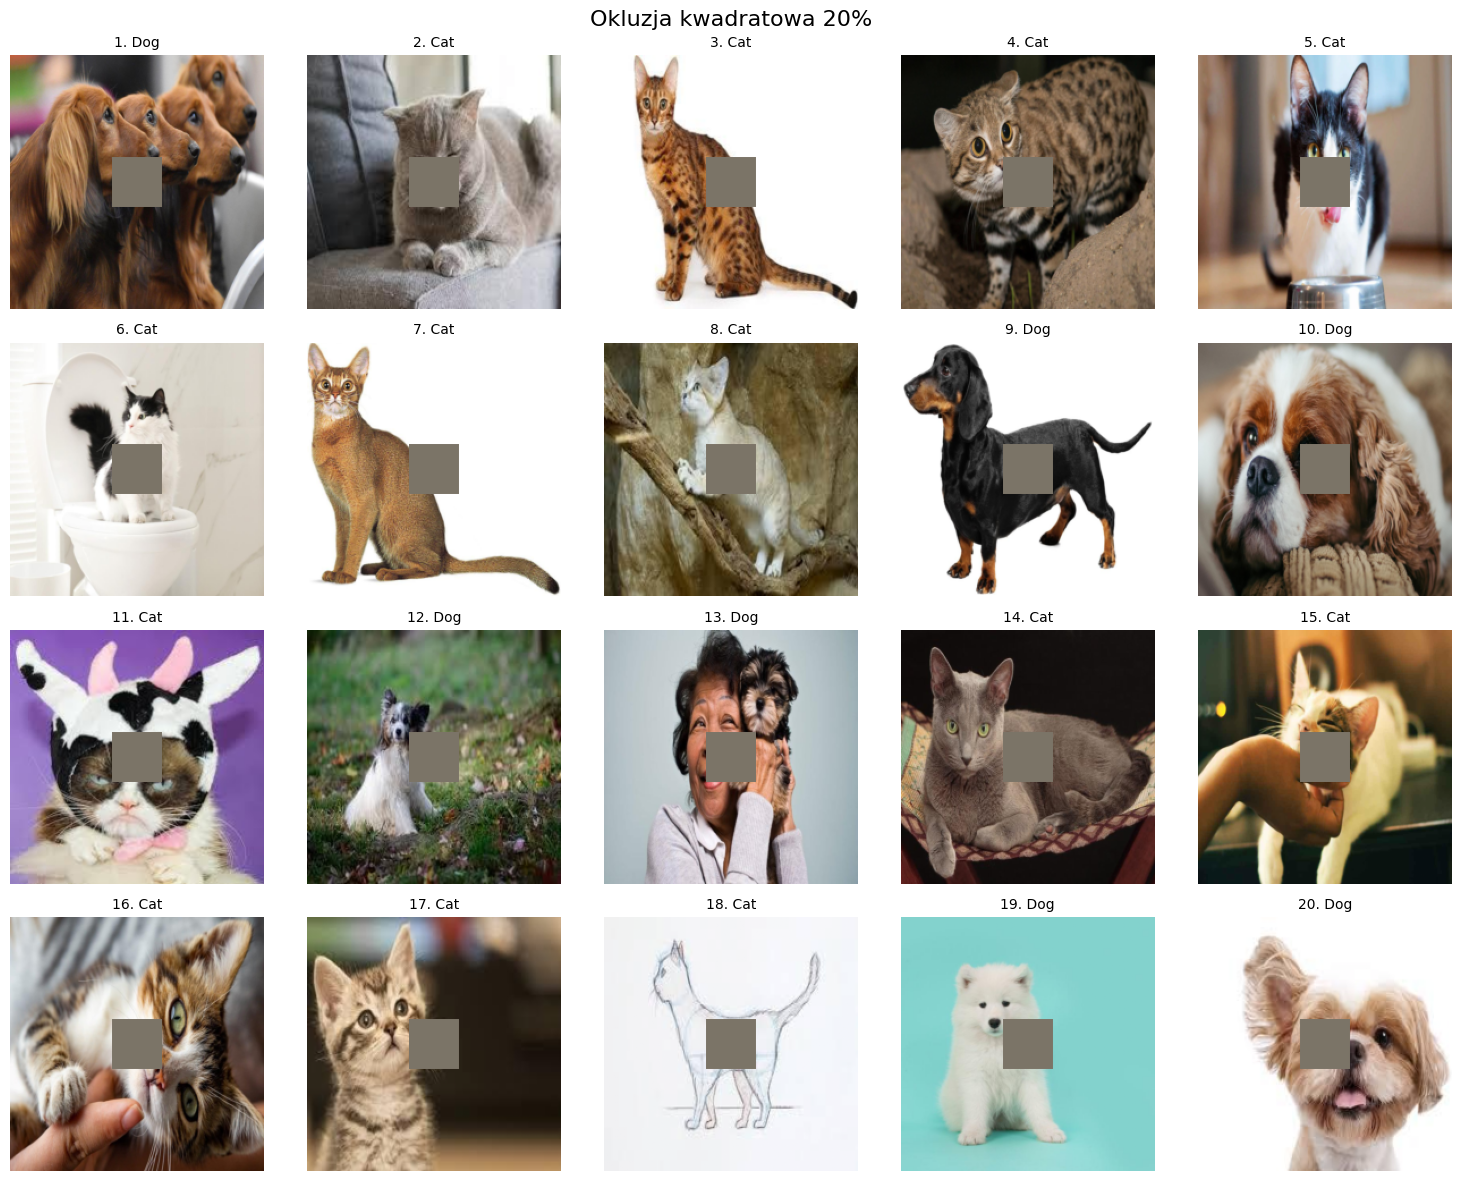

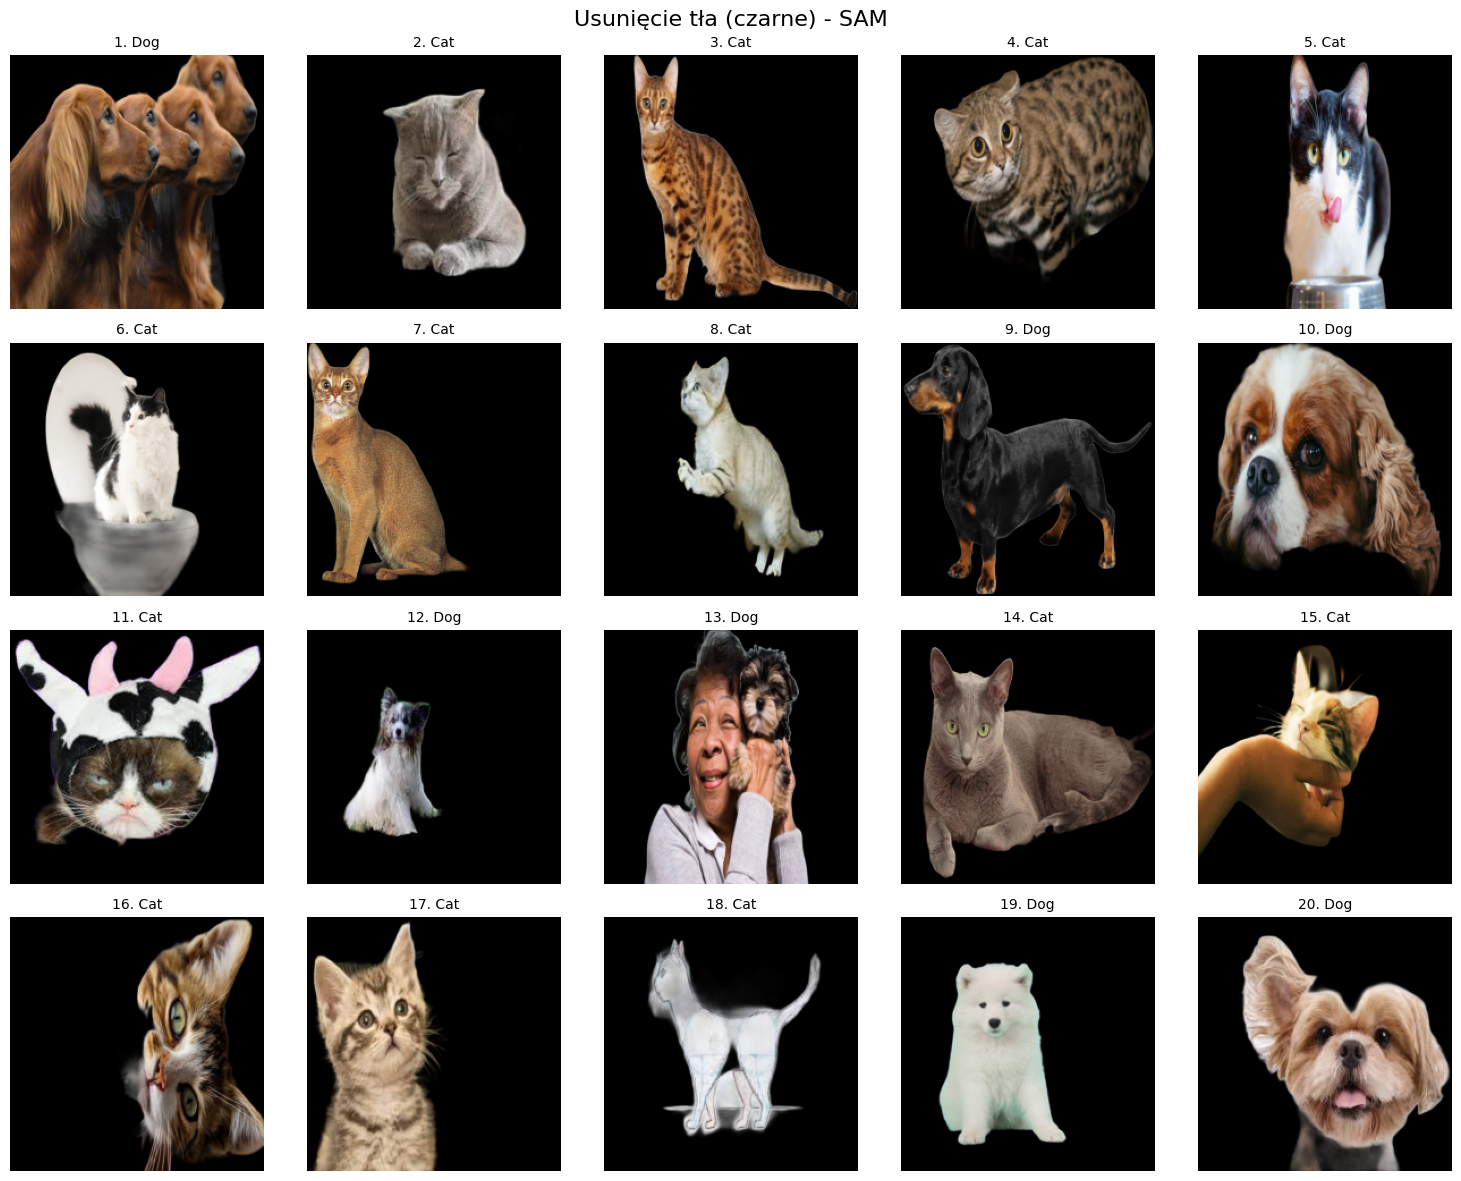

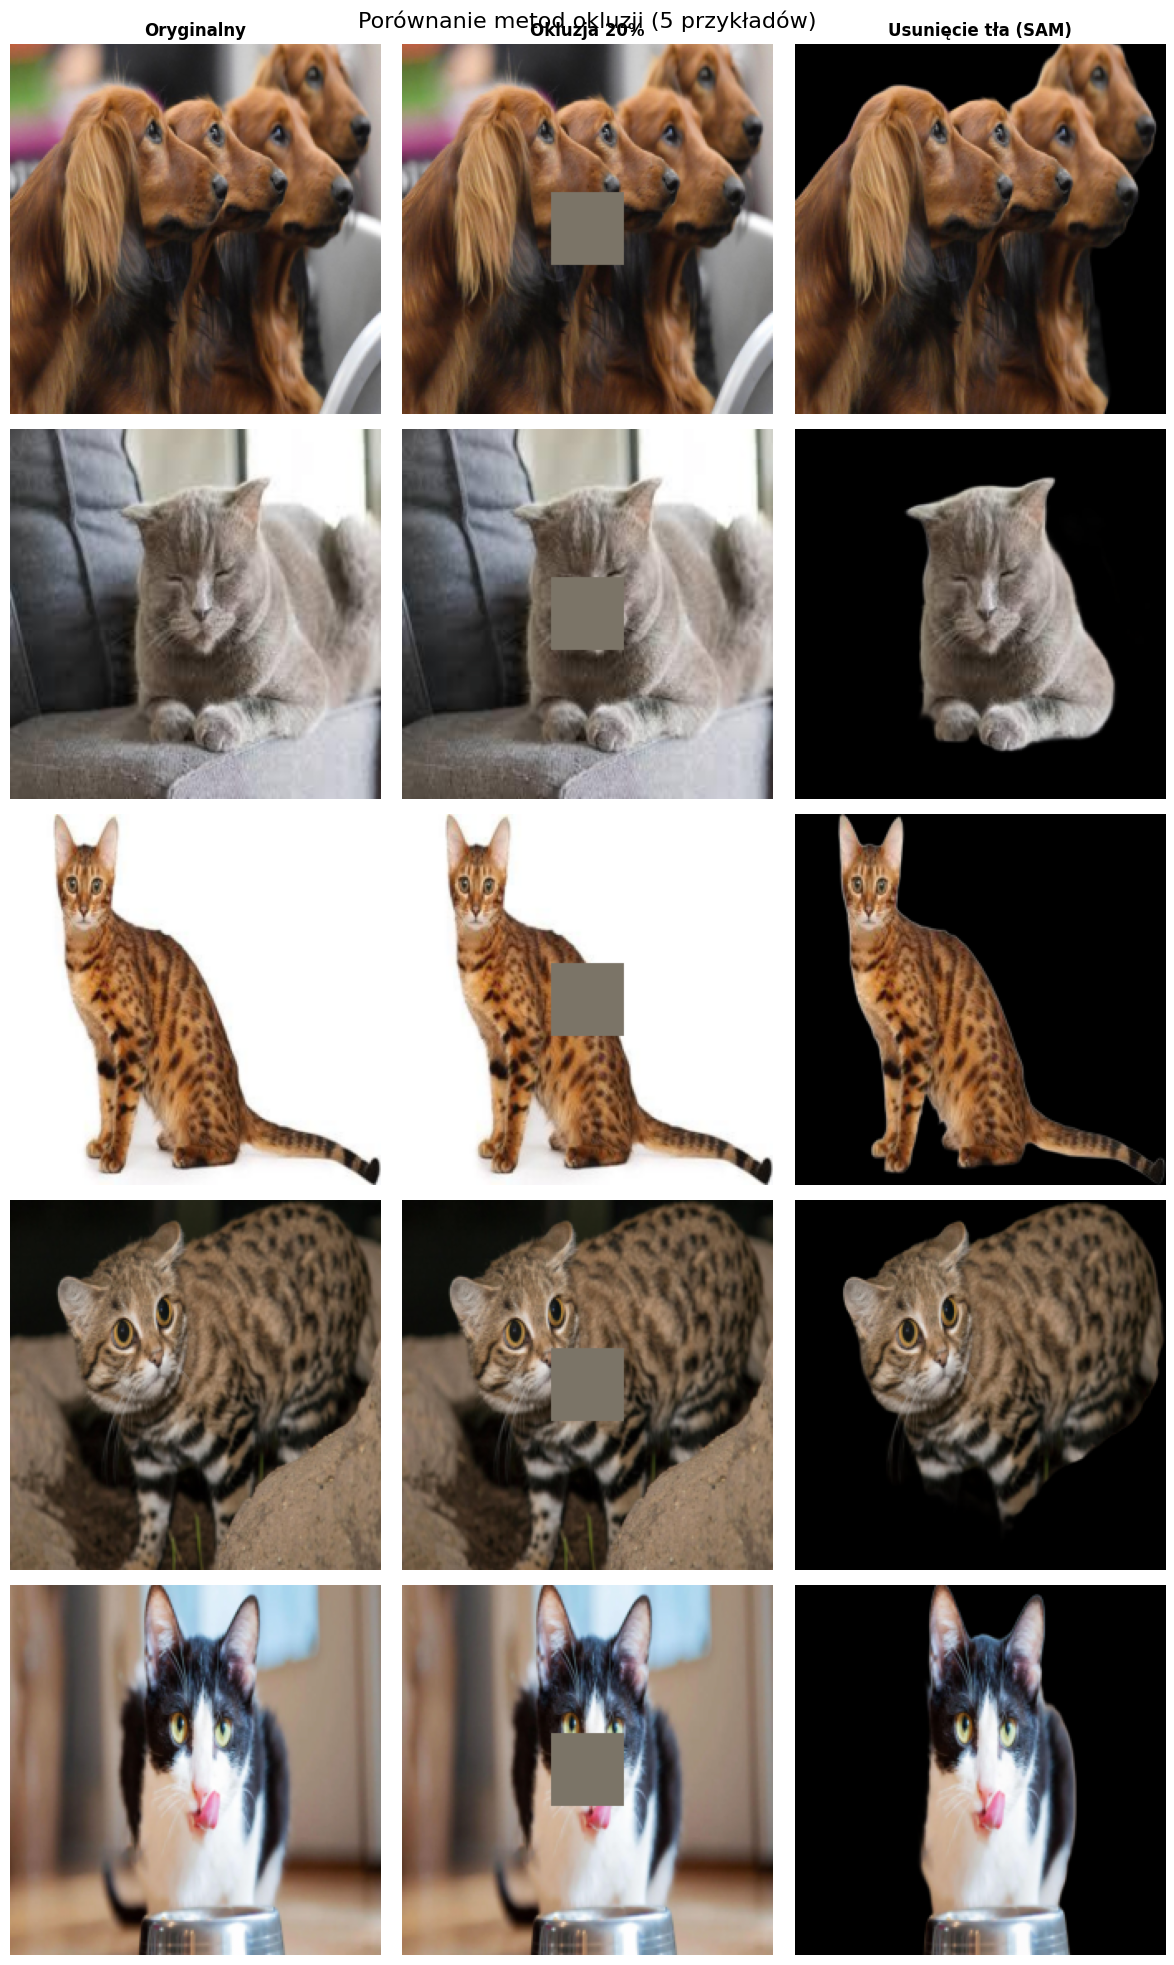

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def denormalize_image(image):
    device = image.device
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    img_denorm = image * std + mean
    img_denorm = torch.clamp(img_denorm, 0, 1)
    return img_denorm.permute(1, 2, 0).cpu().numpy()

# Zbierz wszystkie obrazy do jednej listy
all_images = []
all_labels = []
for images, labels in dataloader:
    all_images.append(images)
    all_labels.append(labels)
all_images = torch.cat(all_images, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Losowy wybór 20 obrazów
import random
random.seed(42)
indices = random.sample(range(len(all_images)), 20)

# Przygotuj obrazy z różnymi okluzjami
original_images = [all_images[i] for i in indices]
occluded_20_images = [apply_occlusion_square(all_images[i], occlusion_percent=20) for i in indices]
bg_removed_images = [apply_background_removal(all_images[i], device) for i in indices]
labels_selected = [all_labels[i].item() for i in indices]

# Wykres 1: Okluzja kwadratowa 20%
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Okluzja kwadratowa 20%', fontsize=16)

for idx, (ax, img, label) in enumerate(zip(axes.flat, occluded_20_images, labels_selected)):
    img_display = denormalize_image(img)
    ax.imshow(img_display)
    ax.axis('off')
    label_name = "Cat" if label == 0 else "Dog"
    ax.set_title(f'{idx+1}. {label_name}', fontsize=10)

plt.tight_layout()
plt.show()

# Wykres 2: Usunięcie tła (SAM)
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Usunięcie tła (czarne) - SAM', fontsize=16)

for idx, (ax, img, label) in enumerate(zip(axes.flat, bg_removed_images, labels_selected)):
    img_display = denormalize_image(img)
    ax.imshow(img_display)
    ax.axis('off')
    label_name = "Cat" if label == 0 else "Dog"
    ax.set_title(f'{idx+1}. {label_name}', fontsize=10)

plt.tight_layout()
plt.show()

# Wykres 3: Porównanie obok siebie (5 przykładów)
fig, axes = plt.subplots(5, 3, figsize=(12, 20))
fig.suptitle('Porównanie metod okluzji (5 przykładów)', fontsize=16)

for row in range(5):
    # Oryginalny
    img_display = denormalize_image(original_images[row])
    axes[row, 0].imshow(img_display)
    axes[row, 0].axis('off')
    if row == 0:
        axes[row, 0].set_title('Oryginalny', fontsize=12, fontweight='bold')
    label_name = "Cat" if labels_selected[row] == 0 else "Dog"
    axes[row, 0].set_ylabel(f'{label_name}', fontsize=11, fontweight='bold')

    # Okluzja 20%
    img_display = denormalize_image(occluded_20_images[row])
    axes[row, 1].imshow(img_display)
    axes[row, 1].axis('off')
    if row == 0:
        axes[row, 1].set_title('Okluzja 20%', fontsize=12, fontweight='bold')

    # Usunięcie tła
    img_display = denormalize_image(bg_removed_images[row])
    axes[row, 2].imshow(img_display)
    axes[row, 2].axis('off')
    if row == 0:
        axes[row, 2].set_title('Usunięcie tła (SAM)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



### Ewaluacja

In [ ]:

#Wczytanie modeli
model_resnet = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
model_resnet.eval()

model_efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT).to(device)
model_efficientnet.eval()


# Test 1: Okluzja kwadratowa
print("\n=== TEST 1: Okluzja kwadratowa ===")
occlusion_levels = list(range(0, 100, 5))
resnet_acc_square = []
effnet_acc_square = []

for occ in occlusion_levels:
    acc_r = compute_accuracy(model_resnet, dataloader, occlusion_type="square", occlusion_percent=occ)
    acc_e = compute_accuracy(model_efficientnet, dataloader, occlusion_type="square", occlusion_percent=occ)
    resnet_acc_square.append(acc_r)
    effnet_acc_square.append(acc_e)
    print(f"Okluzja {occ}% -> ResNet: {acc_r:.4f}, EfficientNet: {acc_e:.4f}")

# Test 2: Usunięcie tła (czarne tło)
print("\n=== TEST 2: Usunięcie tła  ===")
acc_r = compute_accuracy(model_resnet, dataloader, occlusion_type="background_removal")
acc_e = compute_accuracy(model_efficientnet, dataloader, occlusion_type="background_removal")
resnet_acc_bg = acc_r
effnet_acc_bg = acc_e
print(f"Czarne tło -> ResNet: {acc_r:.4f}, EfficientNet: {acc_e:.4f}")

# Wykresy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Okluzja kwadratowa
axes[0].plot(occlusion_levels, resnet_acc_square, marker='o', label='ResNet18')
axes[0].plot(occlusion_levels, effnet_acc_square, marker='o', label='EfficientNet-B0')
axes[0].set_title("Accuracy - Okluzja kwadratowa")
axes[0].set_xlabel("Procent okluzji")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)
axes[0].legend()

# Wykres 2: Różnica dla okluzji kwadratowej
diff_square = [e - r for e, r in zip(effnet_acc_square, resnet_acc_square)]
axes[1].plot(occlusion_levels, diff_square, marker='o', color='green')
axes[1].set_title("Różnica accuracy (EfficientNet - ResNet)")
axes[1].set_xlabel("Procent okluzji")
axes[1].set_ylabel("Różnica accuracy")
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Wykres porównania z usunięciem tła
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
methods = ['Baseline\n(bez okluzji)', 'Okluzja 50%\n(kwadrat)', 'Usunięcie tła\n(SAM)']
resnet_scores = [resnet_acc_square[0], resnet_acc_square[10], resnet_acc_bg]
effnet_scores = [effnet_acc_square[0], effnet_acc_square[10], effnet_acc_bg]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, resnet_scores, width, label='ResNet18', alpha=0.8)
bars2 = ax.bar(x + width/2, effnet_scores, width, label='EfficientNet-B0', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Porównanie metod okluzji')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(True, alpha=0.3)

# Dodaj wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Porównanie metod
print("\n=== PODSUMOWANIE ===")
print(f"Baseline (bez okluzji):")
print(f"  ResNet: {resnet_acc_square[0]:.4f}, EfficientNet: {effnet_acc_square[0]:.4f}")
print(f"\nOkluzja kwadratowa 50%:")
print(f"  ResNet: {resnet_acc_square[10]:.4f}, EfficientNet: {effnet_acc_square[10]:.4f}")
print(f"\nUsunięcie tła (czarne):")
print(f"  ResNet: {resnet_acc_bg:.4f}, EfficientNet: {effnet_acc_bg:.4f}")


=== TEST 1: Okluzja kwadratowa ===
Okluzja 0% -> ResNet: 0.8407, EfficientNet: 0.8594
Okluzja 5% -> ResNet: 0.8422, EfficientNet: 0.8565
Okluzja 10% -> ResNet: 0.8207, EfficientNet: 0.8465
Okluzja 15% -> ResNet: 0.7920, EfficientNet: 0.8508
Okluzja 20% -> ResNet: 0.7360, EfficientNet: 0.8436
Okluzja 25% -> ResNet: 0.7044, EfficientNet: 0.8336
Okluzja 30% -> ResNet: 0.6643, EfficientNet: 0.8164
Okluzja 35% -> ResNet: 0.6327, EfficientNet: 0.7948
Okluzja 40% -> ResNet: 0.6026, EfficientNet: 0.7862
Okluzja 45% -> ResNet: 0.5581, EfficientNet: 0.7676
Okluzja 50% -> ResNet: 0.4390, EfficientNet: 0.7245
Okluzja 55% -> ResNet: 0.3400, EfficientNet: 0.7073
Okluzja 60% -> ResNet: 0.2755, EfficientNet: 0.6585
Okluzja 65% -> ResNet: 0.2123, EfficientNet: 0.5868
Okluzja 70% -> ResNet: 0.1693, EfficientNet: 0.5179
Okluzja 75% -> ResNet: 0.1105, EfficientNet: 0.4319
Okluzja 80% -> ResNet: 0.0631, EfficientNet: 0.3630
Okluzja 85% -> ResNet: 0.0273, EfficientNet: 0.2640
Okluzja 90% -> ResNet: 0.0086,